<a href="https://colab.research.google.com/github/naoya1110/nitkc-ncku-ai-robotics/blob/main/Week07_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook we are going to learn about:

*   transfer learning

So far we have learned how to build and train deep neural network models from scratch. Transfer learning is a technique to shortcut some of these process. Starting point of transfer learning is a model already trained with other dataset. Such model is called pre-trained model. Then only parameters of some specific layers in the pre-trained model is trained with new dataset while rest of parameters are fixed as pre-trained. By using transfer learning the model can achieve higher performance with less training time comparedd from training from scratch. 

**GPU**

Please make sure your runtime type is GPU (cuda).

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


**General Packages**

Let's import some general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

# Data Preparation

We are going to train a model with cats vs dogs dataset. So please download and extract `cats_vs_dogs_dataset`.

In [3]:
os.system("curl gdrive.sh | bash -s https://drive.google.com/file/d/1WY8xxCmDn7z3u3-Edov0msZvY7x-tWmL/view?usp=sharing")
os.system("unzip /content/cats_vs_dogs_dataset.zip")

0

Then create datasets with `torchvision.datasets.ImageFolder`. Here we implement standardization and some data augmentation too.

In [37]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

means = (0.488, 0.455, 0.417)
stds = (0.257, 0.251, 0.253)

xy_train = ImageFolder(root="cats_vs_dogs_dataset/train",
                       transform=transforms.Compose([
                                 transforms.Resize((128, 128)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(means, stds),
                                 transforms.RandomRotation(degrees=10),    # data augmentation
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
                                 ])
                       )

xy_test = ImageFolder(root="cats_vs_dogs_dataset/test",
                      transform=transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize(means, stds)
                                ])
                      )

classnames = {0:"cat", 1:"dog"}

We will use a part of training data as validation data.

In [39]:
import torch

n_samples = len(xy_train) # n_samples is 25000
train_size = int(n_samples * 0.8) # train_size is 20000
valid_size = n_samples - train_size

xy_train, xy_valid = torch.utils.data.random_split(xy_train, [train_size, valid_size])

print(len(xy_train))
print(len(xy_valid))

20000
5000


Then we create dataloaders for training, validation and test data.

In [40]:
from torch.utils.data import DataLoader

train_loader = DataLoader(xy_train, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(xy_valid, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(xy_test, batch_size=32, shuffle=False, num_workers=2)

# Model Building

**Load Pretrained Model**

Now we load a pretrained model. The model architecture is called VGG16, one of well-known image recognition models. This model is pretrained with very large scale image dataset called Imagenet that contains 1,281,167 of images with 1000 categories.

In [28]:
import torchvision.models as models

model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now we fix all parametes in the model as pretrained.

In [29]:
for param in model.parameters():
    param.requires_grad = False

Note that the number of output nodes of the last layer `model.classifier[6]` is 1000. This is because this model is pretrained with Imagenet dataset that contains 1000 categories of images. 

In [30]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

Now we want to train this model with our cats_vs_dogs dataset. Therefore we have to change the number of output node to 2 from 1000.

In [31]:
import torch.nn as nn

model.classifier[6] = nn.Linear(4096, 2)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

By redefining `model.classifier[6]` layer, its parameters are now trainable.

In [32]:
print(model.classifier[6].weight)
print(model.classifier[6].bias)

Parameter containing:
tensor([[-4.0168e-03, -1.1916e-02,  5.0560e-03,  ...,  1.0920e-02,
          1.5262e-02, -1.0489e-02],
        [-6.0436e-03, -8.9419e-03, -8.9966e-07,  ..., -6.7161e-03,
          7.2481e-03, -5.0411e-03]], requires_grad=True)
Parameter containing:
tensor([-0.0112,  0.0048], requires_grad=True)


The we load the model to GPU.

In [33]:
model = model.to(device)

# Training

**Loss Function**


In [34]:
loss_func = nn.CrossEntropyLoss()

**Optimizer**


In [35]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-4)

**Training Loop**







In [41]:
epochs = 5
best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_accuracy = 0
    train_loss = 0
    valid_accuracy = 0
    valid_loss = 0

    model.train()          # set model to training mode

    for x_batch, y_batch in tqdm(train_loader):      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
        
        optimizer.zero_grad()                  # reset gradients to 0
        y_pred = model(x_batch)                # do prediction
        loss = loss_func(y_pred, y_batch)        # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                           # accumulate loss value
        y_pred_label = torch.argmax(y_pred, dim=1)          # 
        train_accuracy += (y_pred_label == y_batch).sum()   # count up number of correct predictions

    with torch.no_grad():     # disable autograd for saving memory usage
        model.eval()          # set model to evaluation mode

        for x_batch, y_batch in tqdm(valid_loader):   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            y_pred = model(x_batch)            # do prediction
            loss = loss_func(y_pred, y_batch)    # measure loss

            valid_loss += loss.item()                          # accumulate loss value
            y_pred_label = torch.argmax(y_pred, dim=1)        # convert y_pred vector to target class index
            valid_accuracy += (y_pred_label == y_batch).sum()  # count up number of correct predictions

            # save the model if the accuracy is better than before
            if valid_accuracy > best_accuracy:
                torch.save(model.state_dict(), best_model_path)
                best_accuracy = valid_accuracy

    train_accuracy = train_accuracy/len(xy_train)   # determine accuracy for training data
    valid_accuracy = valid_accuracy/len(xy_valid)      # determin accuracy for test data
    train_loss = train_loss/len(train_loader)           # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)              # determin loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}\n")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)

Epoch 1/5


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

Train: Accuracy=0.917 Loss=0.194, Valid: Accuracy=0.944 Loss=0.128

Epoch 2/5


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

Train: Accuracy=0.937 Loss=0.151, Valid: Accuracy=0.948 Loss=0.124

Epoch 3/5


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

Train: Accuracy=0.941 Loss=0.142, Valid: Accuracy=0.949 Loss=0.122

Epoch 4/5


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

Train: Accuracy=0.939 Loss=0.146, Valid: Accuracy=0.955 Loss=0.111

Epoch 5/5


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

Train: Accuracy=0.946 Loss=0.137, Valid: Accuracy=0.956 Loss=0.111



**Learning Curves**

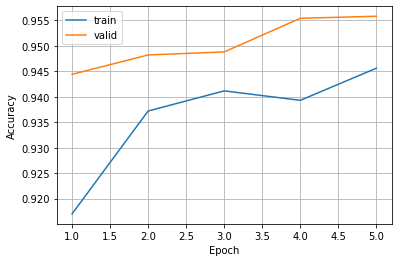

In [42]:
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

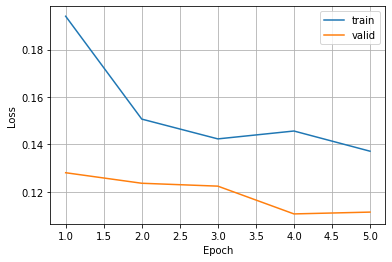

In [43]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Evaluation

**Load the Best Model**

In [44]:
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 2)
model = model.to(device)
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

**Validation Accuracy**

In [45]:
correct_count = 0
y_true_all = np.array([])
y_pred_label_all = np.array([])

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in valid_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        y_pred_label = torch.argmax(y_pred, dim=1)

        correct_count += (y_batch == y_pred_label).sum()

        y_true_all = np.append(y_true_all, y_batch.to("cpu").numpy())
        y_pred_label_all = np.append(y_pred_label_all, y_pred_label.to("cpu").numpy())

valid_accuracy = correct_count/len(xy_valid)
valid_accuracy = valid_accuracy.item()
print(f"Validation Accuracy = {valid_accuracy:.3f}")

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

Validation Accuracy = 0.955


**Confusion Matrix for Validation Data**

Text(0.5, 1.0, 'confusion matrix')

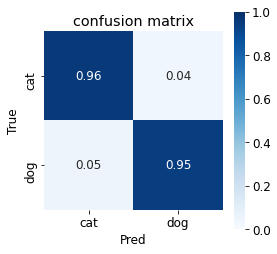

In [50]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_true_all, y_pred_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(4,4))
plt.rcParams["font.size"]=12
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

**Predictions for Test Data**

Let's see predictions for some test data.

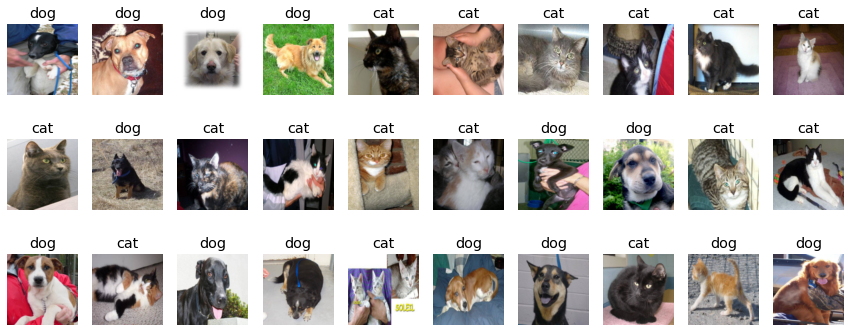

In [51]:
with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        y_pred_label = torch.argmax(y_pred, dim=1)

        plt.figure(figsize=(15, 6))
        for i in range(30):
            image = x_batch[i].to("cpu").numpy()
            image = np.transpose(image, (1,2,0))

            image[:,:,0] = ((image[:,:,0]*stds[0])+means[0])
            image[:,:,1] = ((image[:,:,1]*stds[1])+means[1])
            image[:,:,2] = ((image[:,:,2]*stds[2])+means[2])

            plt.subplot(3, 10, i+1)
            plt.imshow(image)

            pred_class = classnames[y_pred_label[i].item()]
            plt.title(pred_class)
            plt.axis("off")
        
        break

# Submission

Now we make predictions for all the test data.

In [52]:
y_pred_label_all = []

with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        y_pred_label = torch.argmax(y_pred, dim=1)
        y_pred_label_all = np.append(y_pred_label_all, y_pred_label.to("cpu").numpy())

y_pred_label_all = y_pred_label_all.astype("uint8")
print(y_pred_label_all)

[1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0
 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1
 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1
 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1
 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0
 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1
 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1
 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0
 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0
 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1
 1 1 0 1 1 0 0 1 1 1 0 0 

Please set your username here.

In [ ]:
username = "naoya"

Now we create a submission file named `{username}_transfer_submission.csv`.

In [ ]:
df_submit = pd.DataFrame()
df_submit["id"] = np.arange(1000)
df_submit["label"] = y_pred_label_all

df_submit.to_csv(f"{username}_transfer_submission.csv", index = False)

df_submit

,id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
995,995,0
996,996,1
997,997,1
998,998,0


**Submission Form**

Now you can find your submission file `{username}_transfer_submission.csv` in the Files tab. Please download it to your local storage and submit it from the submission form below.

https://forms.gle/BfcbrAqBCYicCSzt9

**Ranking**

You can check your score and standing.

https://drive.google.com/file/d/1a8f0EKU3POHCpOR6wfocHk27FWpEn6nx/view?usp=sharing

In [ ]:
os.system("curl gdrive.sh | bash -s https://drive.google.com/file/d/1a8f0EKU3POHCpOR6wfocHk27FWpEn6nx/view?usp=sharing")
df_ranking = pd.read_csv("/content/cats_vs_dogs_ranking.csv")
os.remove("/content/cats_vs_dogs_ranking.csv")

df_ranking.head(100)

,Rank,Username,Accuracy,Submission Time (UTC)
0,1,naoya_vgg16,0.978,2021-08-22 13:01:12
1,2,iwamoto_test,0.771,2021-08-20 13:13:36
2,3,naoya,0.743,2021-08-21 02:21:47
3,4,iwamoto,0.723,2021-08-20 05:08:27
4,5,naoya_pytorch,0.723,2021-08-20 04:53:29


# Conclusion

We used pretrained VGG16 model as an example of transfer learning, but many different pretrained models are available in `torchvision.models`. Please refer the link below and try to use some of them.

https://pytorch.org/vision/stable/models.html